In [1]:
# conda install statsmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # for fig save
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

# Initial dataset overview and exploration

This dataset has data on the number of passengers transported by mode of transport in Ukraine, years 1995-2020
Source for dataset: https://www.kaggle.com/datasets/kseniakryvogubchenko/ua-passengers-1995-2020?resource=download

In [3]:
# import data set and check top rows
df = pd.read_csv('Data/ua_passengers_1995-2020.csv', sep=';')
df.head()

,year,railway,sea,river,auto_bus,air,tram,trolley,subway
0,1995,577431.5,7817.0,3594.1,3483173.0,1914.9,821652.3,1358736.9,561012.4
1,1996,538568.7,5044.6,2735.9,3304600.0,1724.0,788026.2,1590439.3,536304.1
2,1997,500838.8,4311.3,2443.1,2512147.2,1484.5,1265349.2,2388087.6,507897.0
3,1998,501428.7,3838.3,2356.5,2403424.6,1163.9,1450735.2,2717998.1,668456.4
4,1999,486810.4,3084.3,2269.4,2501707.5,1087.0,1456755.4,2735241.0,724425.5


In [4]:
# check general info about data base
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      26 non-null     int64  
 1   railway   26 non-null     float64
 2   sea       26 non-null     float64
 3   river     26 non-null     float64
 4   auto_bus  26 non-null     float64
 5   air       26 non-null     float64
 6   tram      26 non-null     float64
 7   trolley   26 non-null     float64
 8   subway    26 non-null     float64
dtypes: float64(8), int64(1)
memory usage: 2.0 KB


In [5]:
# check if have missing values
df.isnull().sum() 

year        0
railway     0
sea         0
river       0
auto_bus    0
air         0
tram        0
trolley     0
subway      0
dtype: int64

In [6]:
df.describe()

,year,railway,sea,river,auto_bus,air,tram,trolley,subway
count,26.000000,26.000000,26.000000,26.000000,2.600000e+01,26.000000,2.600000e+01,2.600000e+01,26.000000
mean,2007.500000,407824.500000,11857.934615,1546.111538,3.003374e+06,5156.550000,9.450878e+05,1.607972e+06,743352.684615
std,7.648529,126653.115605,15028.172028,894.806411,8.487019e+05,3572.125665,2.826577e+05,5.904788e+05,130840.813545
min,1995.000000,68332.500000,52.600000,256.500000,1.083873e+06,1087.000000,4.227532e+05,5.789996e+05,411149.700000
25%,2001.250000,398649.800000,4494.625000,604.925000,2.427995e+06,1804.350000,7.432981e+05,1.123551e+06,704022.650000
50%,2007.500000,445509.400000,6643.800000,1701.700000,3.183320e+06,4863.050000,8.106706e+05,1.469561e+06,752764.200000
75%,2013.750000,474513.125000,9213.050000,2207.450000,3.693202e+06,7246.925000,1.127235e+06,1.916250e+06,821579.550000
max,2020.000000,577431.500000,45836.000000,3594.100000,4.369126e+06,13705.800000,1.456755e+06,2.735241e+06,958693.900000


### Key Insights

- **Railway Passengers**: The average number of railway passengers is approximately **407,825**, with a maximum of **577,432**.
- **Sea Transport**: The passengers transported by sea average around **11,858**, with a maximum of **45,836**.
- **River Transport**: Average river transport numbers are relatively low, around **1,546** passengers, with a max of **3,594**.
- **Auto Bus Passengers**: Auto bus transport has the highest average, with about **3,003,374** and reaching a maximum of **4,369,126**.
- **Air Travel**: The average air passengers number around **5,157**, with a notable peak at **13,706**.
- **Trams, Trolleys, and Subways**: These modes show varied usage, with averages of **945,088**, **1,607,972**, and **743,353** respectively, reflecting urban transit patterns.

## Outlier exploration

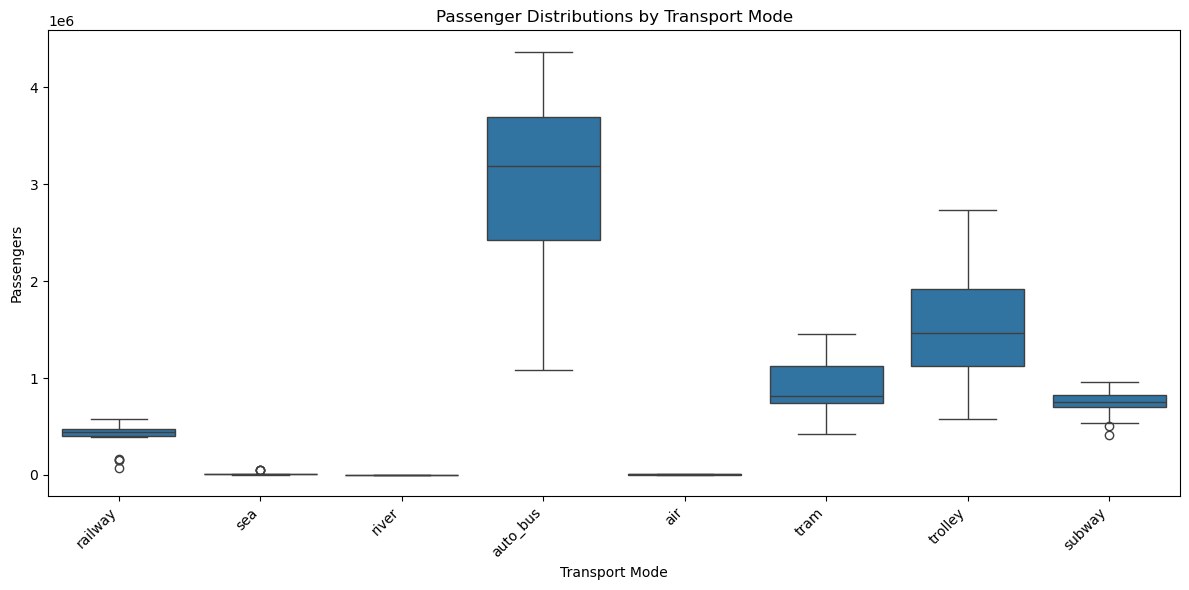

In [19]:
cols = [c for c in df.columns if c.lower() != 'year']

# melt to long format for seaborn
long_df = df[cols].melt(var_name='mode', value_name='passengers')

plt.figure(figsize=(12, 6))
sns.boxplot(data=long_df, x='mode', y='passengers', showfliers=True)
plt.title('Passenger Distributions by Transport Mode')
plt.xlabel('Transport Mode')
plt.ylabel('Passengers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join('Fig', 'boxplot_all_modes.png'), dpi=150)
plt.show()


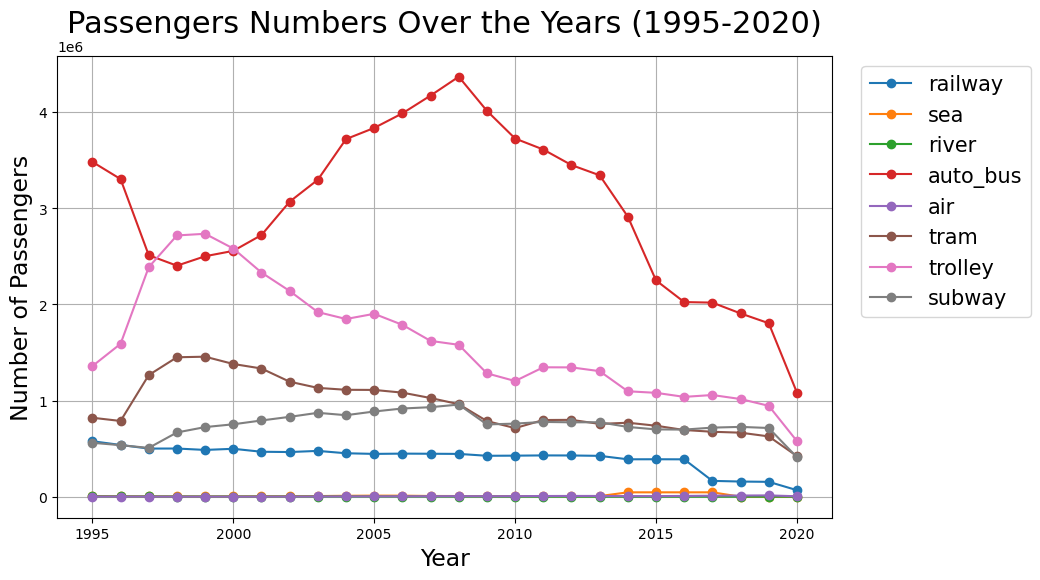

In [7]:
# Plotting the data
plt.figure(figsize=(10, 6))

# Plot each mode of transport
for column in df.columns[1:]:  # Skip the first column which is 'year'
    plt.plot(df['year'], df[column], marker='o', label=column)

# Adding titles and labels
plt.title('Passengers Numbers Over the Years (1995-2020)', fontsize=22)
plt.xlabel('Year', fontsize=17)
plt.ylabel('Number of Passengers', fontsize=17)
plt.xticks(df['year'][::5]) 
plt.legend(loc='upper right', bbox_to_anchor=(1.27, 1), fontsize=15)
plt.grid()

# save figure into folder Fig
plt.savefig(os.path.join('Fig', 'Distribution of Passengers Over the Years.png'))  

# Show the plot
plt.show()


# Correlation Analysis of Transportation Modes


In [8]:
df.corr()

,year,railway,sea,river,auto_bus,air,tram,trolley,subway
year,1.000000,-0.839162,0.388244,-0.955349,-0.373893,0.871876,-0.775787,-0.819275,0.013991
railway,-0.839162,1.000000,-0.142259,0.750551,0.636013,-0.731078,0.644500,0.658417,0.233066
sea,0.388244,-0.142259,1.000000,-0.414970,-0.199928,0.274012,-0.299401,-0.360244,0.005046
river,-0.955349,0.750551,-0.414970,1.000000,0.410044,-0.801581,0.688482,0.713988,0.031593
auto_bus,-0.373893,0.636013,-0.199928,0.410044,1.000000,-0.254136,0.213914,0.182152,0.642898
air,0.871876,-0.731078,0.274012,-0.801581,-0.254136,1.000000,-0.730587,-0.753776,0.084224
tram,-0.775787,0.644500,-0.299401,0.688482,0.213914,-0.730587,1.000000,0.986080,0.305879
trolley,-0.819275,0.658417,-0.360244,0.713988,0.182152,-0.753776,0.986080,1.000000,0.204147
subway,0.013991,0.233066,0.005046,0.031593,0.642898,0.084224,0.305879,0.204147,1.000000


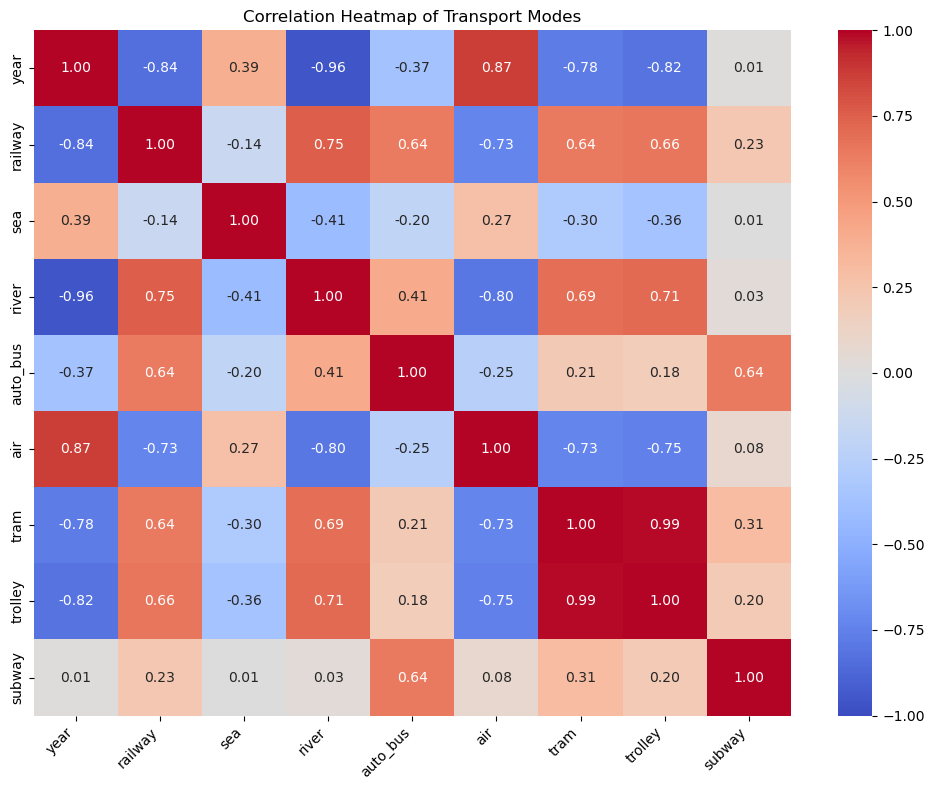

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Heatmap of Transport Modes')
plt.tight_layout()
plt.savefig(os.path.join('Fig', 'correlation_matrix.png'))
plt.show()


## Overview

The correlation matrix provided reveals the relationships between different modes of transportation over a specified period (years). Each value in the matrix indicates the strength and direction of the linear relationship between pairs of transportation modes, with values ranging from -1 to 1. A value closer to 1 indicates a strong positive correlation, while a value closer to -1 indicates a strong negative correlation. A value close to 0 indikates the lack of correlation.

# Correlation Analysis of Transportation Modes

The correlation matrix reveals various relationships among transportation modes over time:

**Year:** Strong negative correlation with **railway** (-0.84), indicating a decline in railway usage over the years, while showing a positive correlation with **air travel** (0.87), indicating growth in this sector.

**Railway:** Positive correlation with **river** (0.75) suggests potential coexistence, but negative correlations with **auto/bus** (-0.64) and **tram** (-0.73) imply a trade-off in usage.

**Sea:** Shows moderate negative correlation with **river** (-0.42), but generally low correlations with other modes, indicating relative independence.

**River:** Strong negative correlations with **tram** (-0.8) and **trolley** (-0.71) indicate that increases in river transport may reduce reliance on these public transit options.

**Auto/Bus:** Positive correlation with **air** (0.64) reflects overlapping user demographics, while negative correlation with **railway** (-0.37) indicates a substitution effect.

**Air:** Significant negative correlations with both **railway** (-0.73) and **trolley** (-0.75) signify competition between these modes.

**Tram and Trolley:** Extremely high positive correlation (0.99) indicates they follow similar trends and are affected similarly by declines in other modes like rail.

**Subway:** Exhibits weak overall correlations, with the strongest correlation being with **auto/bus** (0.64), suggesting limited interdependence with other transport modes.



## Visual check for linear or nonlinear relationships

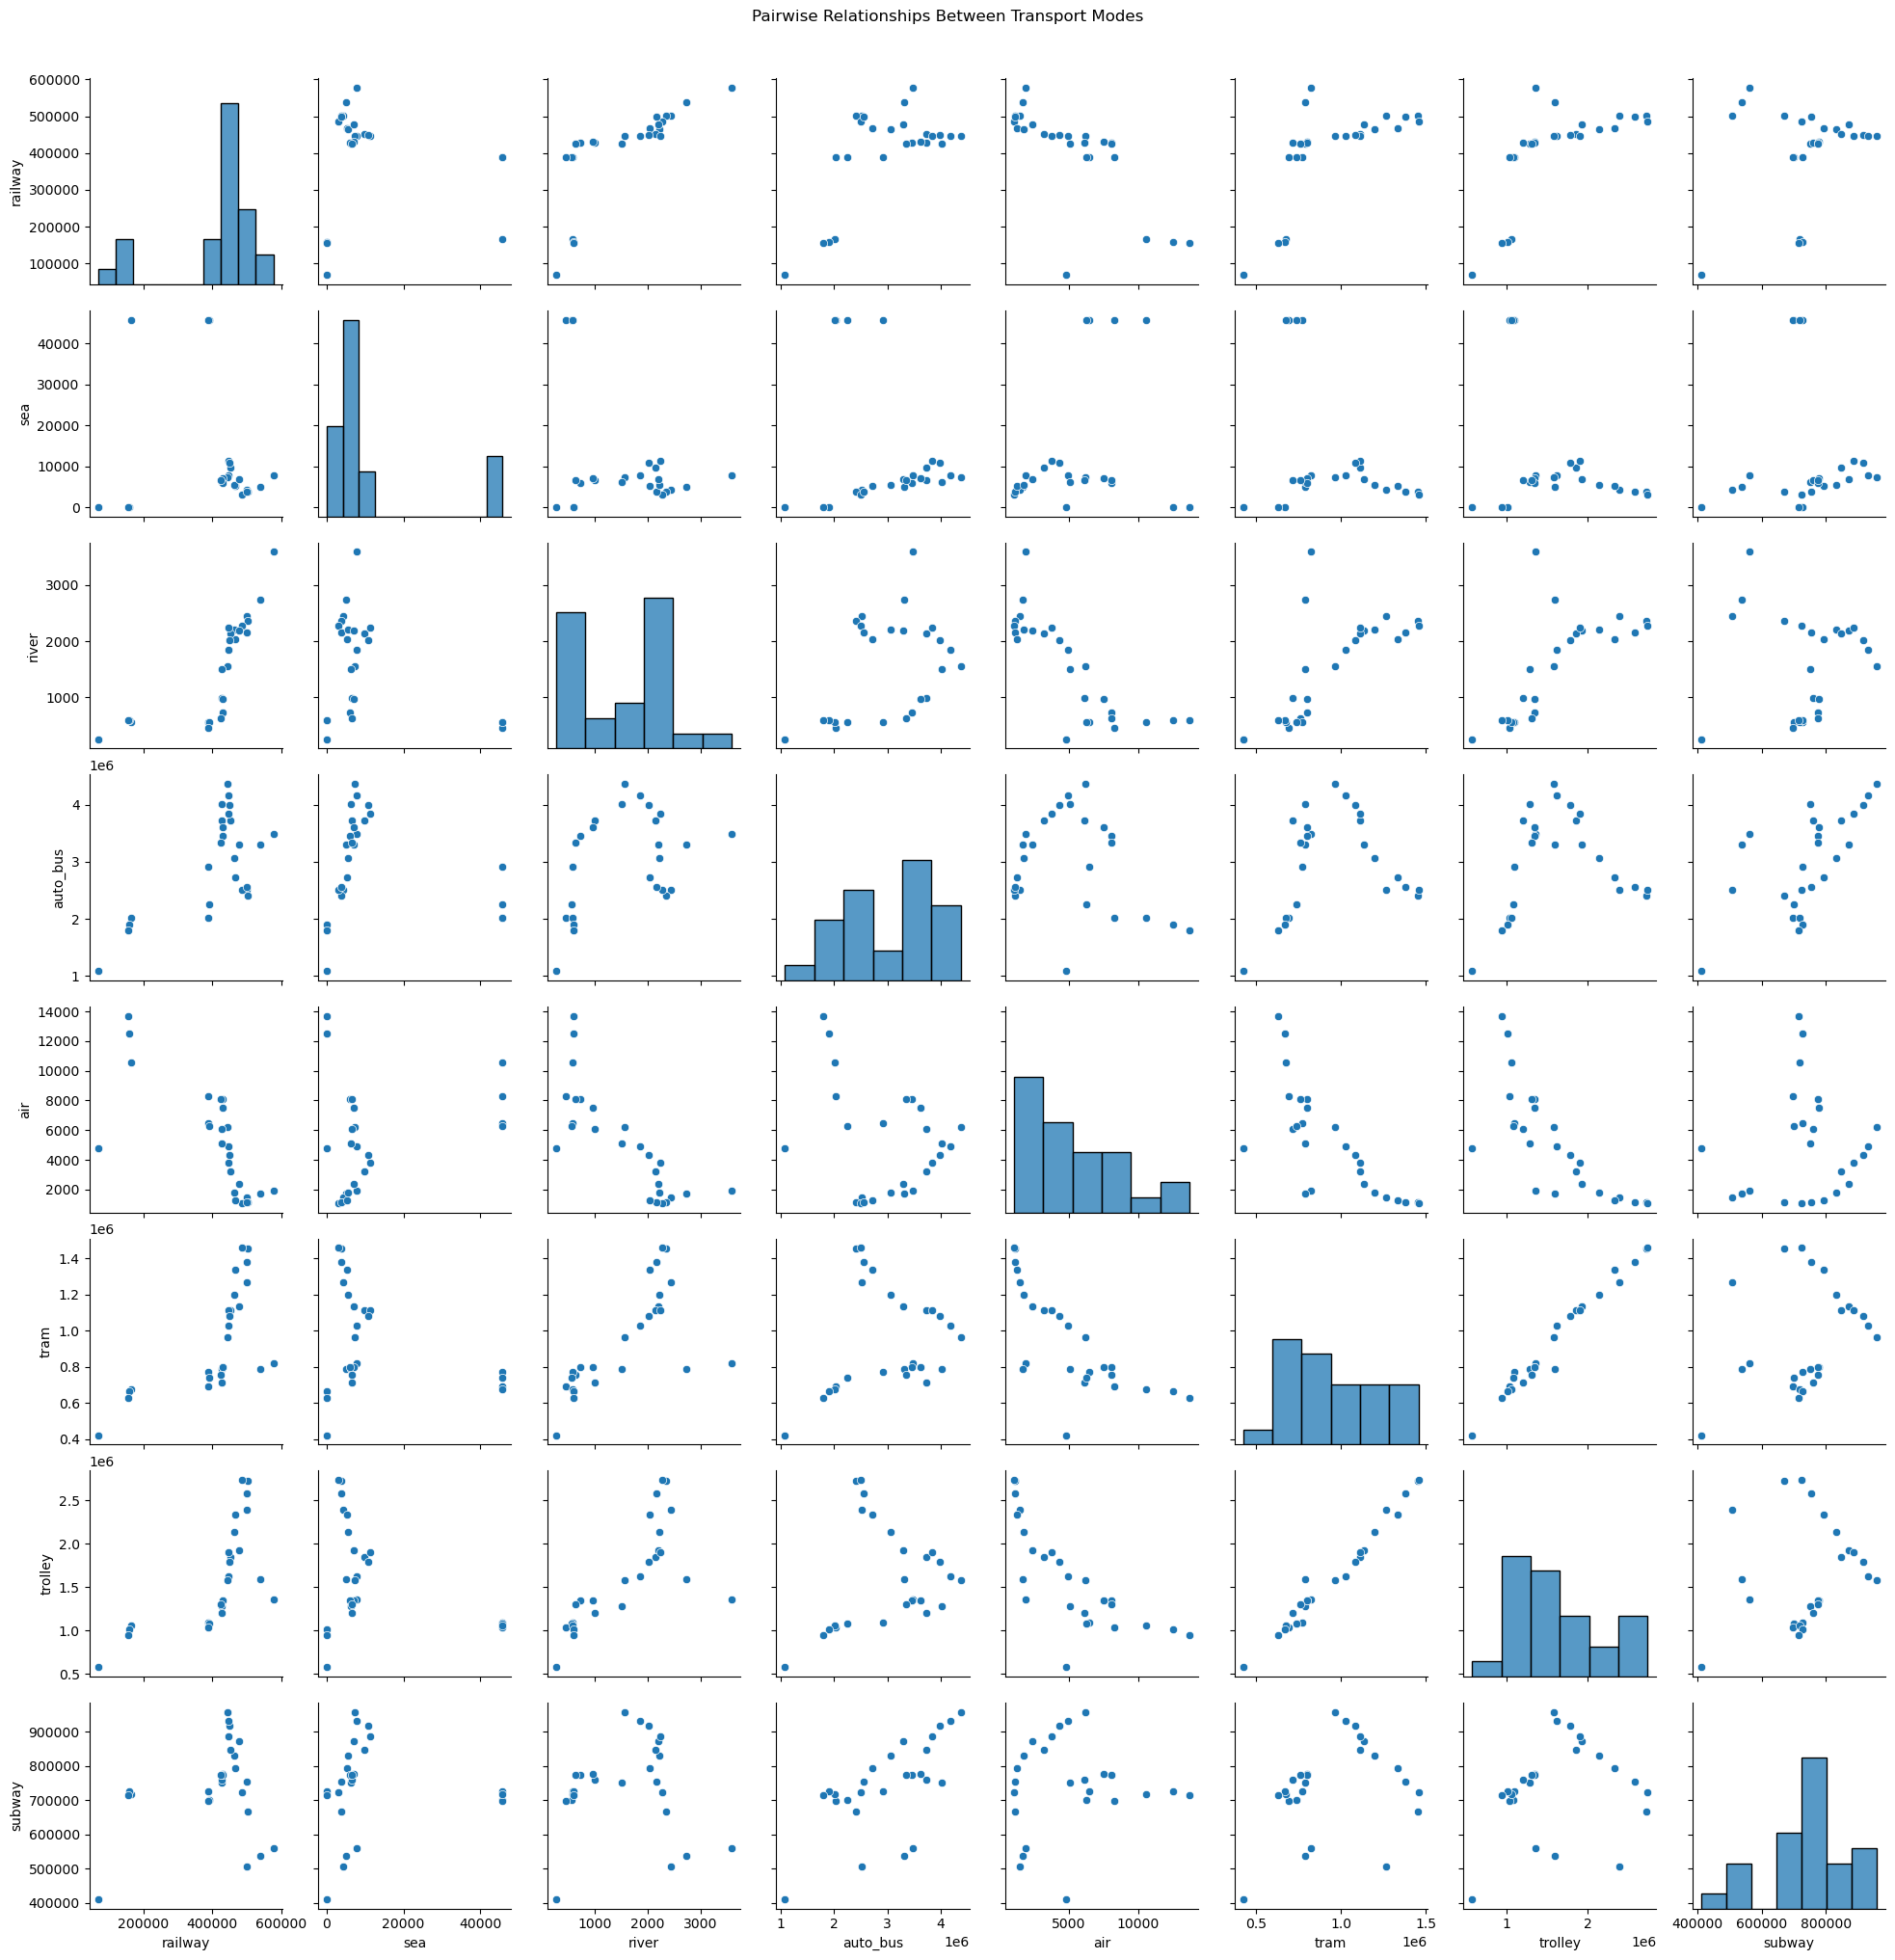

In [10]:
sns.pairplot(df.drop(columns=['year']))
plt.suptitle('Pairwise Relationships Between Transport Modes', y=1.02)
plt.savefig(os.path.join('Fig', 'pairwise_relationships.png'))
plt.show()

On this visualizations clearly visible that out of all combinations **Trolley** and **Tram** have the most liner relationshops supporting the result from correlation analysis of 0.99. 

## Yearly Growth Rates

    year   railway      sea   river   auto_bus      air       tram    trolley  \
0   1995  577431.5   7817.0  3594.1  3483173.0   1914.9   821652.3  1358736.9   
1   1996  538568.7   5044.6  2735.9  3304600.0   1724.0   788026.2  1590439.3   
2   1997  500838.8   4311.3  2443.1  2512147.2   1484.5  1265349.2  2388087.6   
3   1998  501428.7   3838.3  2356.5  2403424.6   1163.9  1450735.2  2717998.1   
4   1999  486810.4   3084.3  2269.4  2501707.5   1087.0  1456755.4  2735241.0   
5   2000  498683.0   3760.5  2163.3  2557514.6   1164.0  1380921.2  2581880.0   
6   2001  467825.3   5270.8  2034.2  2722001.6   1289.9  1333782.0  2332086.3   
7   2002  464810.4   5417.9  2211.9  3069136.3   1767.5  1196402.6  2140314.9   
8   2003  476742.4   6929.4  2194.1  3297504.5   2374.7  1132181.9  1920746.2   
9   2004  452225.6   9678.4  2140.2  3720326.4   3228.5  1112394.2  1848843.3   
10  2005  445553.1  11341.2  2247.6  3836514.5   3813.1  1110957.5  1902760.9   
11  2006  448421.7  10901.3 

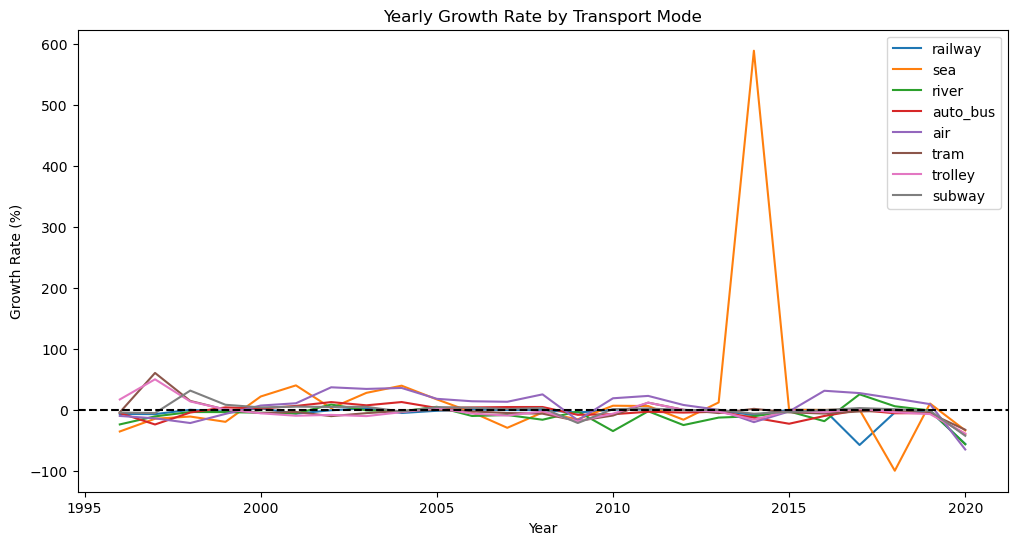

In [11]:
growth = df.copy()
print(df)
for col in df.columns[1:]: # [0] for year col
    growth[col] = df[col].pct_change() * 100

print(growth)

plt.figure(figsize=(12, 6))
for col in growth.columns[1:]:
    plt.plot(df['year'], growth[col], label=col)

plt.axhline(0, color='black', linestyle='--')
plt.title('Yearly Growth Rate by Transport Mode')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.legend()
plt.savefig(os.path.join('Fig', 'growth_rate.png'))
plt.show()


We can observe modest growth rates (≈ +/−20%) until 2013–2014 for all types of transportation, when **sea** (orange) shows a huge outlier spike (~500–600%). After the spike, sea growth immediately reverts toward zero—typical of a one-off anomaly rather than a structural shift. **Subway** and **bus** hover closer to zero than others, suggesting steadier demand for these types of transportation.


2019–2020: broad, synchronized declines across nearly all modes (rail, river, tram, trolley, air, bus), consistent with macro shocks (e.g., COVID-19).




In [12]:
cols = [c for c in df.columns if c.lower() == 'sea'] + ['year']
tmp = df[['year','sea']].copy()
tmp['yoy_%'] = tmp['sea'].pct_change()*100
print(tmp.loc[tmp['year'].between(2012, 2016)])


    year      sea       yoy_%
17  2012   5921.0  -16.181821
18  2013   6642.0   12.176997
19  2014  45776.0  589.190003
20  2015  45802.0    0.056798
21  2016  45746.0   -0.122265


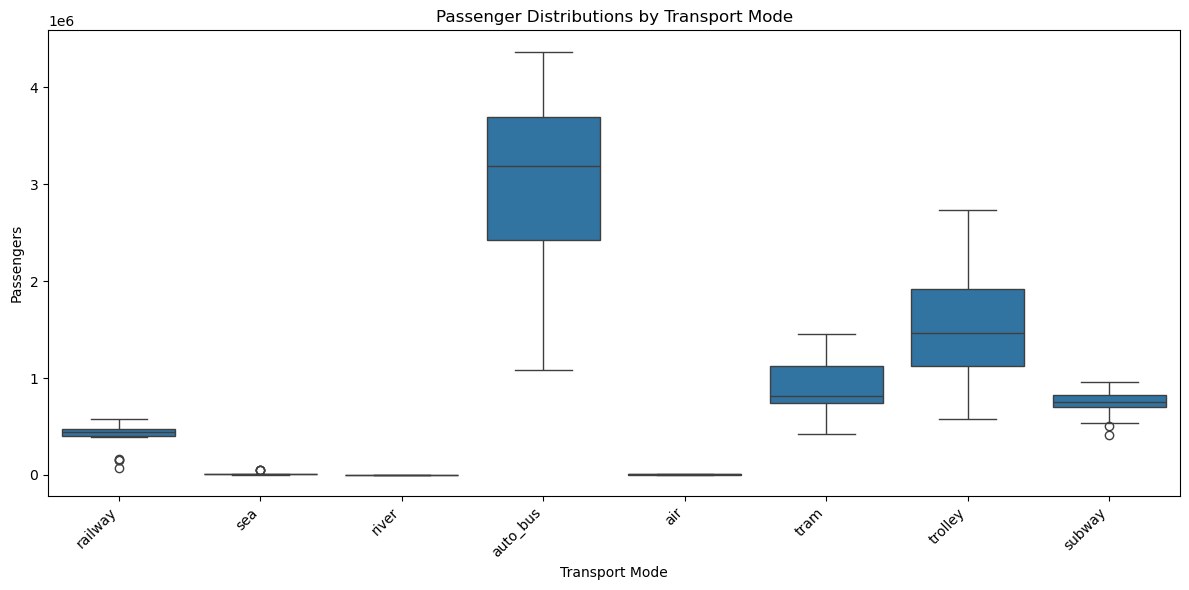

In [18]:

cols = [c for c in df.columns if c.lower() != 'year']

# melt to long format for seaborn
long_df = df[cols].melt(var_name='mode', value_name='passengers')

plt.figure(figsize=(12, 6))
sns.boxplot(data=long_df, x='mode', y='passengers', showfliers=True)
plt.title('Passenger Distributions by Transport Mode')
plt.xlabel('Transport Mode')
plt.ylabel('Passengers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join('Fig', 'boxplot_all_modes.png'), dpi=150)
plt.show()
